# Model training

In this file, I want to build and train some models and select the best predictor of ace/no ace.

## Importing libraries

In [1]:
# Import everything from my_libraries.py
from my_libraries import *  # noqa: F403

# Other utilities
import tennis_utils
import dataframe_utils

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2025-03-21 11:35:13.742769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read into dataframe
df = pd.read_csv("datasets/task_set.csv")

# Clean dataframe
df = dataframe_utils.clean_dataframe(df)

In [3]:
# Split data while maintaining the proportion of 'is_ace'
X = df.drop("is_ace", axis=1)
y = df["is_ace"]

# Perform stratified split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Save the train dataset in a new csv file
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv("datasets/train_dataset.csv")

In [4]:
# Impute missing values and feature engineer
X_train, X_test = [dataframe_utils.impute_data(df) for df in (X_train, X_test)]


In [5]:
X_train

,surface,serve_side,serve_number,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y,hitter_hand,receiver_hand
185010,clay,ad,1,1.603,-11.350,2.754,111.3,91.4,1.003,0.038,4.625,-0.510,82.1,15.054,-11.472,1.535,15.197,-3.570,right,right
70356,hard,deuce,1,-1.169,-11.059,2.950,128.9,100.8,1.198,0.406,5.669,1.287,89.1,12.148,-11.514,-1.011,15.274,3.867,right,right
161333,clay,ad,1,0.235,-11.089,2.852,124.7,102.2,1.193,-0.448,5.742,-0.714,91.1,12.711,-11.612,0.751,15.802,-1.933,right,right
7428,hard,deuce,1,-1.088,-11.364,2.903,116.3,90.0,1.198,1.926,5.299,3.543,80.4,15.177,-11.639,-0.953,14.103,3.755,right,left
42492,hard,deuce,2,-0.861,-11.212,2.797,104.1,79.2,1.078,0.117,4.185,0.227,71.6,15.955,-11.831,-0.883,15.664,3.412,left,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140963,hard,ad,1,1.153,-11.390,2.862,130.7,103.9,1.089,0.118,5.329,-0.275,93.6,11.247,-11.863,1.060,13.948,-3.592,right,right
112587,hard,ad,1,0.907,-11.323,2.888,110.0,87.1,1.200,-1.892,5.332,-3.025,78.2,14.748,-11.957,1.027,13.725,-3.670,right,right
143005,clay,deuce,2,-1.214,-11.067,2.715,104.1,86.1,1.100,0.012,5.009,0.749,78.3,13.325,-11.360,-0.839,15.246,4.262,right,right
62226,hard,ad,1,1.409,-11.309,2.854,124.1,96.9,1.025,-0.329,4.831,-1.094,87.7,13.065,-11.510,1.046,13.310,-3.621,right,right


## Imbalanced dataset

Almost 92% of serves are not aces. The data is highly imbalanced. For the machine learning model to learn effectively, the data has to be balanced. I am using the random oversampler for this. Note that there are not too many unique ways you can serve an ace. ie: high serve speed, aim at the lines, hit where your opponent doesn't expect you to but this will still be to the leftmost or rightmost of the ad/deuce court.

In [6]:
y_train.value_counts()

is_ace
0    105993
1      9045
Name: count, dtype: int64

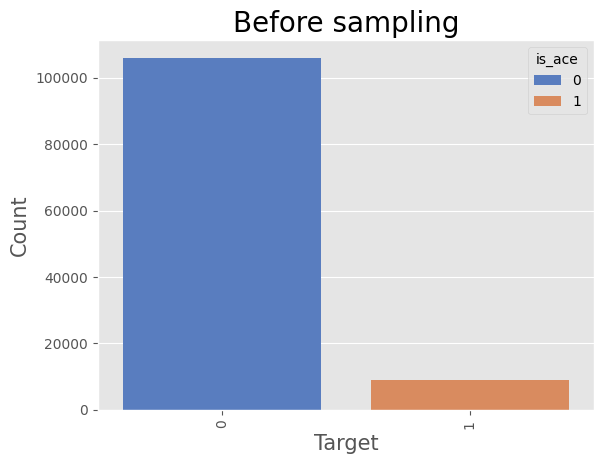

In [7]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("Before sampling", fontsize=20)
plt.show()

In [8]:
X_train.columns

Index(['surface', 'serve_side', 'serve_number', 'ball_hit_y', 'ball_hit_x',
       'ball_hit_z', 'ball_hit_v', 'ball_net_v', 'ball_net_z', 'ball_net_y',
       'ball_bounce_x', 'ball_bounce_y', 'ball_bounce_v', 'ball_bounce_angle',
       'hitter_x', 'hitter_y', 'receiver_x', 'receiver_y', 'hitter_hand',
       'receiver_hand'],
      dtype='object')

In [9]:
# Define features that should not be interpolated
protected_columns = [
    "surface",
    "serve_side",
    "serve_number",
    "hitter_hand",
    "receiver_hand",
]

# Separate features into protected and numeric
X_protected = X_train[protected_columns]
X_numeric = X_train.drop(columns=protected_columns)

# Apply BorderlineSMOTE only to numeric features
smote = BorderlineSMOTE(kind="borderline-1", random_state=42)
X_numeric_resampled, y_resampled = smote.fit_resample(X_numeric, y_train)

# Find nearest neighbors in the original dataset to assign non-interpolated values
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_numeric)
indices = nn.kneighbors(X_numeric_resampled, return_distance=False).flatten()

# Retrieve protected values from original data
X_protected_resampled = X_protected.iloc[indices].reset_index(drop=True)

# Combine back into final DataFrame
X_resampled = pd.concat(
    [
        X_protected_resampled,
        pd.DataFrame(X_numeric_resampled, columns=X_numeric.columns),
    ],
    axis=1,
)

# Convert back to DataFrame and restore column names
X_train = X_resampled.copy()
y_train = y_resampled


In [10]:
X_train

,surface,serve_side,serve_number,hitter_hand,receiver_hand,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y
0,clay,ad,1,right,right,1.603000,-11.350000,2.754000,111.300000,91.400000,1.003000,0.038000,4.625000,-0.510000,82.100000,15.054000,-11.472000,1.535000,15.197000,-3.570000
1,hard,deuce,1,right,right,-1.169000,-11.059000,2.950000,128.900000,100.800000,1.198000,0.406000,5.669000,1.287000,89.100000,12.148000,-11.514000,-1.011000,15.274000,3.867000
2,clay,ad,1,right,right,0.235000,-11.089000,2.852000,124.700000,102.200000,1.193000,-0.448000,5.742000,-0.714000,91.100000,12.711000,-11.612000,0.751000,15.802000,-1.933000
3,hard,deuce,1,right,left,-1.088000,-11.364000,2.903000,116.300000,90.000000,1.198000,1.926000,5.299000,3.543000,80.400000,15.177000,-11.639000,-0.953000,14.103000,3.755000
4,hard,deuce,2,left,right,-0.861000,-11.212000,2.797000,104.100000,79.200000,1.078000,0.117000,4.185000,0.227000,71.600000,15.955000,-11.831000,-0.883000,15.664000,3.412000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211981,clay,deuce,1,right,right,-1.176027,-11.513489,2.833385,116.532873,97.310488,1.166105,-0.323147,5.720271,0.122874,87.757344,13.713985,-11.744217,-1.416293,12.959049,3.448280
211982,hard,deuce,1,right,right,-0.936458,-11.094103,2.701695,135.079108,108.640510,0.978045,-0.148252,4.767864,0.258000,98.898726,10.451794,-11.386254,-1.203922,13.249876,3.898324
211983,hard,deuce,1,right,right,-1.085222,-11.261486,2.735401,116.493869,93.003773,1.096892,2.289500,5.108491,3.946137,85.499057,12.649140,-11.791783,-1.092071,14.591755,4.033038
211984,clay,deuce,1,right,right,-0.767214,-11.076301,2.859696,139.584266,112.088806,1.086893,-0.165006,5.111131,0.163501,102.178669,13.942110,-11.451933,-0.911726,15.077135,3.674662


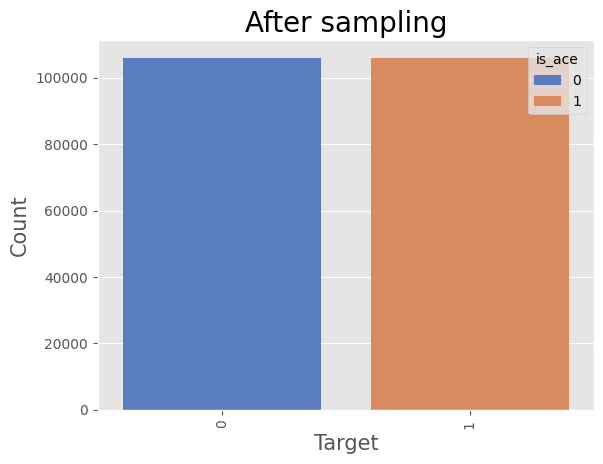

In [11]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("After sampling", fontsize=20)
plt.show()

# Feature Engineering

In [12]:
X_train, X_test = [dataframe_utils.feature_engineer(df) for df in (X_train, X_test)]

In [13]:
X_train

,bin_mean_ball_hit_y,ball_bounce_y,receiver_y,ball_hit_x,ball_net_z,ball_bounce_x,ball_bounce_angle,hitter_x,receiver_x,dist_ball_bounce_x_returner_x,dist_ball_bounce_y_returner_y,bin_mean_speed,bin_mean_ball_hit_z,surface_clay,surface_hard,hitter_hand_left,receiver_hand_left,serve_number,close_to_side_line,close_to_center_line,close_to_service_line
0,0.824588,-0.168997,-0.902120,0.178764,-1.483581,-0.687501,0.142768,1.134956,0.911763,1.183361,1.076071,0.112884,-0.333357,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.530735,0.279581,0.113482,1.810995,0.242343,0.912734,-0.835339,0.929693,0.973754,0.459598,0.690109,1.346496,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.274363,-0.219920,-0.678570,1.642724,0.198089,1.024628,-0.645843,0.450747,1.398830,0.800148,-0.404254,1.001085,-0.333357,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.356322,0.842736,0.098187,0.100238,0.242343,0.345601,0.184168,0.318792,0.031017,-0.139920,-1.213970,0.465345,0.600041,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.356322,0.014978,0.051347,0.952812,-0.819764,-1.361930,0.446028,-0.619551,1.287731,1.862216,1.176582,-0.415807,-0.333357,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211981,-0.530735,-0.011015,0.056301,-0.738252,-0.039959,0.991321,-0.308257,-0.195425,-0.889943,-1.311429,1.289482,0.465345,-0.333357,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
211982,-0.356322,0.022716,0.117760,1.614099,-1.704459,-0.468520,-1.406251,1.554016,-0.655807,-0.380916,1.542702,1.691908,-1.277011,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
211983,-0.356322,0.943369,0.136156,0.675244,-0.652557,0.053590,-0.666664,-0.427890,0.424499,0.368483,-1.314561,0.465345,-1.277011,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
211984,-0.356322,-0.000874,0.087216,1.713953,-0.741050,0.057636,-0.231474,1.233025,0.815264,0.729796,1.438845,2.044368,0.600041,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# Models

In [27]:
def scoring():
    # Train Data Accuracy
    a_s_train = round(accuracy_score(y_train.to_numpy(), y_pred_train), 4)
    f_1_train = round(f1_score(y_train.to_numpy(), y_pred_train), 4)

    # Test Data Accuracy
    a_s_test = round(accuracy_score(y_test.to_numpy(), y_pred), 4)
    f_1_test = round(f1_score(y_test.to_numpy(), y_pred), 4)

    # Precision and Recall for Training Data
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    # Precision and Recall for Test Data
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)

    score_dict = {
        "Accuracy": [a_s_train, a_s_test],
        "F1": [f_1_train, f_1_test],
        "Precision": [train_precision, test_precision],
        "Recall": [train_recall, test_recall],
    }

    # Convert to DataFrame with proper index
    score_df = pd.DataFrame(score_dict, index=["Train", "Test"])
    print(score_df)


def confusion_matrix_display():
    # Confusion Matrix Visualization
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Not Ace", "Ace"],
        yticklabels=["Not Ace", "Ace"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

## Random Forest Classifer

In [16]:
# Got the best split from the GridSearchCV below
rfc = RandomForestClassifier(
    random_state=42, max_depth=4, n_estimators=50, min_samples_split=6
)

# Training Model
rfc.fit(X_train, y_train)
# Save model
joblib.dump(rfc, "rfc_model.joblib")
# Load model
saved_model = joblib.load("rfc_model.joblib")
# Predict
y_pred = saved_model.predict(X_test)
y_pred_train = saved_model.predict(X_train)

       Accuracy      F1  Precision    Recall
Train    0.8623  0.8679   0.834143  0.904428
Test     0.8224  0.4308   0.287924  0.855005


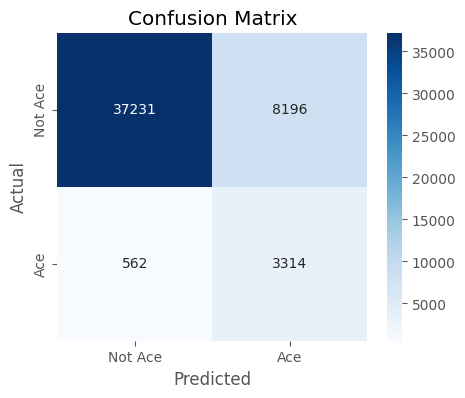

In [28]:
scoring()
confusion_matrix_display()

### Using gridsearch cv for hyper parameter tuning

In [18]:
# param_grid = [
#     {
#         "n_estimators": [20, 50],
#         "max_depth": [5, 7, 10],
#         "min_samples_split": [2, 3, 6],
#     }
# ]

# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(),
#     param_grid=param_grid,
#     cv=2,
#     return_train_score=True,
#     verbose=True,
# )
# grid_search.fit(X_train, y_train)

# # Save the model so you don't have to run Gridsearchcv again.
# # Access the best model
# best_model = grid_search.best_estimator_
# best_parameters = grid_search.best_params_
# best_score = grid_search.best_score_

# # Save the best model to a file using joblib
# joblib.dump(best_model, "best_random_forest_model.joblib")

# # Grid_search.cv_results_ is a dictonary of each iteration of grid search, saving parameters and test and train scores.
# # Converting that to a df and saving as a csv so it can be accessed whenever.

# cv_results_df = pd.DataFrame(grid_search.cv_results_)
# cv_results_df.to_csv("cv_results.csv")

Obtaining the top ten most important features.

In [19]:
# # Extract feature importances
# importances = saved_model.feature_importances_

# # Create a DataFrame for feature importance
# feature_importance_df = pd.DataFrame(
#     {"Feature": X_train.columns, "Importance": importances}
# )

# # Sort features by importance
# top_features = feature_importance_df.sort_values(by="Importance", ascending=False).head(
#     10
# )

# # Display the top 10 features
# print("Top 10 Features for Serve Prediction:")
# print(top_features)

Three of new features engineered have made it into the top 10, two making it to top 3.

In [20]:
# # Visualize feature importance

# plt.figure(figsize=(10, 6))
# plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("Top 10 Features for Serve Prediction")
# plt.gca().invert_yaxis()
# plt.show()

In [21]:
# # Sort features by importance
# worst_features = feature_importance_df.sort_values(
#     by="Importance", ascending=True
# ).head(10)

# # Display the top 10 features
# print("Worst 10 Features for Serve Prediction:")
# print(worst_features)

Dropping more columns

In [22]:
# new_columns_to_drop = ['receiver_hand_left', 'surface_hard', 'close_to_service_line','hitter_hand_left','serve_side_deuce','hitter_x']
# X_train.drop(columns=new_columns_to_drop, inplace=True)
# X_test.drop(columns=new_columns_to_drop, inplace=True)

### XG Boost

       Accuracy      F1  Precision    Recall
Train    0.8567  0.8521   0.880115  0.825819
Test     0.8783  0.4987   0.368746  0.770124


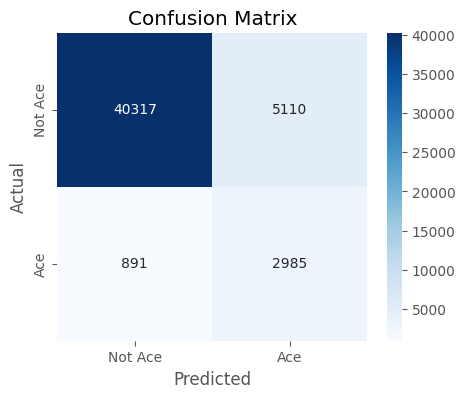

In [29]:
xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    reg_alpha=1,
    reg_lambda=1,
    colsample_bytree=0.85,
    subsample=0.85,
    learning_rate=0.02,
    n_estimators=50,
    max_depth=3,
    min_child_weight=20,
    gamma=10,
)

# Training Model
xgb.fit(X_train, y_train)

# Mode summary
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

scoring()
confusion_matrix_display()

More focus must be given to identifying why serves that are not aces are getting identified as aces.

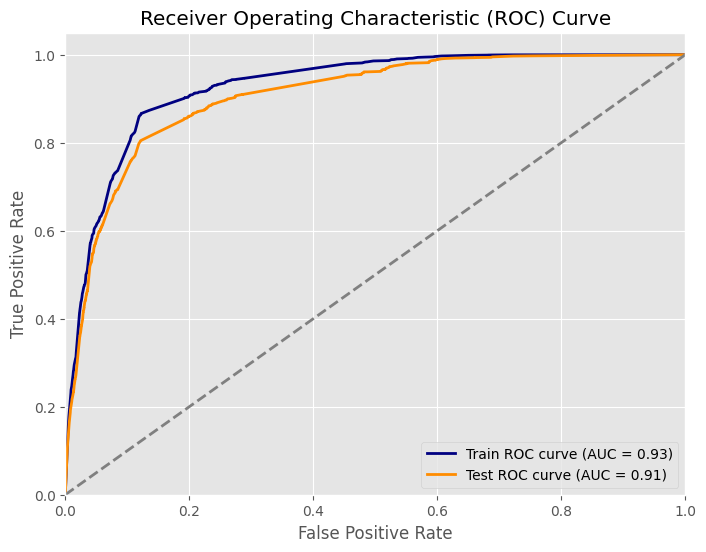

In [30]:
# Probability estimates for the positive class
y_prob_train = xgb.predict_proba(X_train)[:, 1]
y_prob_test = xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_prob_test)

# Compute AUC
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr_train,
    tpr_train,
    color="navy",
    lw=2,
    label=f"Train ROC curve (AUC = {roc_auc_train:.2f})",
)
plt.plot(
    fpr_test,
    tpr_test,
    color="darkorange",
    lw=2,
    label=f"Test ROC curve (AUC = {roc_auc_test:.2f})",
)
plt.plot(
    [0, 1], [0, 1], color="gray", lw=2, linestyle="--"
)  # Random classifier (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [31]:
# Youden's index = TPR - FPR, which is maximized when the threshold gives the best trade-off.
youden_index = tpr_train - fpr_train
optimal_threshold = thresholds_train[
    np.argmax(youden_index)
]  # Find the threshold that maximizes Youden's index
# 7. Apply the optimal threshold to make final predictions
y_pred_optimal = (y_prob_test > optimal_threshold).astype(int)

# 8. Evaluate the model using confusion matrix and other metrics
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

# Print the evaluation metrics
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Optimal Threshold: 0.4890299141407013
Confusion Matrix:
[[39919  5508]
 [  759  3117]]
Accuracy: 0.87
Precision: 0.36
Recall: 0.80
F1-Score: 0.50


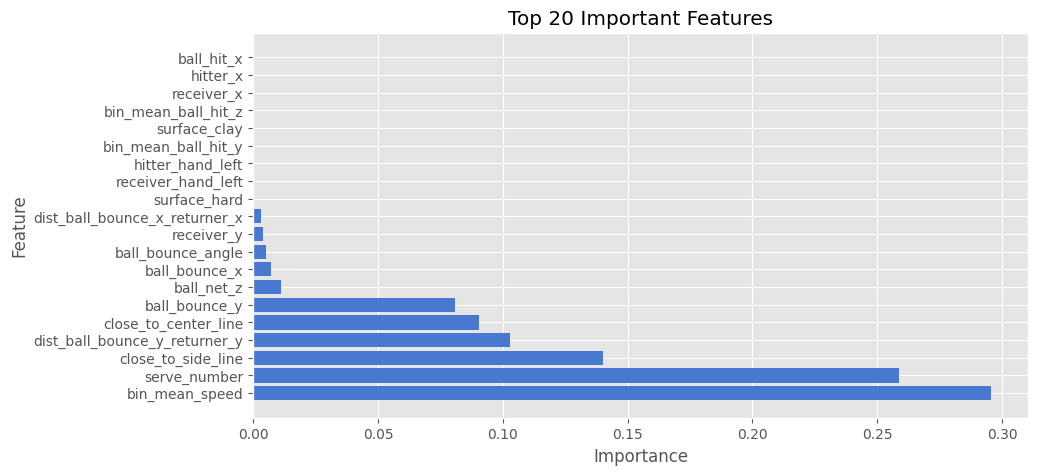

In [32]:
feature_importance = xgb.feature_importances_
feature_names = X_train.columns

# Sort and plot feature importance
feat_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importance}
)
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df["Feature"][:20], feat_importance_df["Importance"][:20])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Important Features")
plt.show()

In [33]:
feat_importance_df

,Feature,Importance
11,bin_mean_speed,0.295670
17,serve_number,0.258608
18,close_to_side_line,0.140049
10,dist_ball_bounce_y_returner_y,0.102866
19,close_to_center_line,0.090624
1,ball_bounce_y,0.081031
4,ball_net_z,0.011322
5,ball_bounce_x,0.007298
6,ball_bounce_angle,0.005200
2,receiver_y,0.004015


In [34]:
# Define a threshold (e.g., remove features with importance < 0.001)
threshold = 0.001

# Select only important features
selected_features = feat_importance_df[feat_importance_df["Importance"] > threshold][
    "Feature"
].tolist()

# Keep only selected features in training and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


       Accuracy      F1  Precision    Recall
Train    0.8774  0.8772   0.878246  0.876199
Test     0.8754  0.5069   0.367851  0.814757


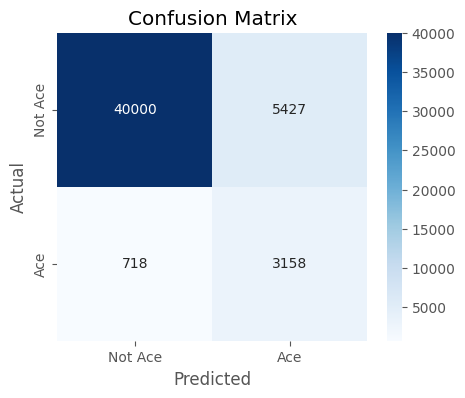

In [35]:
# Train XGBoost with selected features
model_selected = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    reg_alpha=1,
    reg_lambda=1,
    colsample_bytree=0.85,
    subsample=0.85,
    learning_rate=0.02,
    n_estimators=50,
    max_depth=4,
    min_child_weight=20,
    gamma=10,
)
model_selected.fit(X_train_selected, y_train)

# Mode summary
y_pred = model_selected.predict(X_test_selected)
y_pred_train = model_selected.predict(X_train_selected)

scoring()
confusion_matrix_display()


[0]	eval-logloss:0.68390	eval-weighted_logloss:nan
[10]	eval-logloss:0.59950	eval-weighted_logloss:nan
[20]	eval-logloss:0.53922	eval-weighted_logloss:nan
[30]	eval-logloss:0.49324	eval-weighted_logloss:nan
[40]	eval-logloss:0.45866	eval-weighted_logloss:nan
[49]	eval-logloss:0.43187	eval-weighted_logloss:nan
       Accuracy      F1  Precision    Recall
Train    0.8772  0.8772   0.877365  0.877067
Test     0.8744  0.5062   0.366355  0.818627


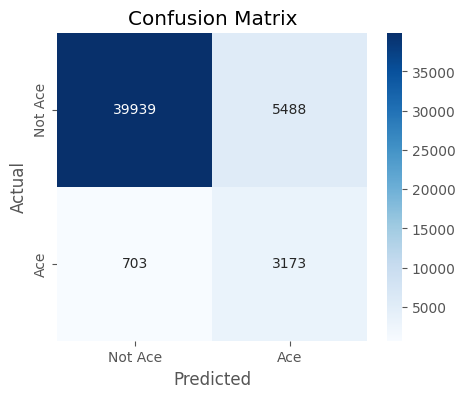

In [36]:
import xgboost

# Convert data to DMatrix format (XGBoost’s optimized data structure)
dtrain = xgboost.DMatrix(X_train_selected, label=y_train)
dtest = xgboost.DMatrix(X_test_selected, label=y_test)


# Define custom weighted log loss function
def weighted_logloss(preds, dtrain, weight_fp=3.0):
    labels = dtrain.get_label()
    epsilon = 1e-9  # To avoid log(0)

    # Compute weighted log loss
    loss = -np.mean(
        labels * np.log(preds + epsilon)
        + weight_fp * (1 - labels) * np.log(1 - preds + epsilon)
    )

    return "weighted_logloss", loss


# Define XGBoost parameters
params = {
    "objective": "binary:logistic",  # Binary classification
    "eta": 0.02,  # Learning rate
    "max_depth": 4,  # Tree depth
    "min_child_weight": 20,
    "gamma": 10,
    "colsample_bytree": 0.85,
    "subsample": 0.85,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "eval_metric": "logloss",  # Default metric for reference
}

# Train the XGBoost model with the custom loss function
model = xgboost.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, "eval")],
    feval=lambda p, d: weighted_logloss(
        p, d, weight_fp=50.0
    ),  # Adjust weight_fp to fine-tune
    early_stopping_rounds=50,
    verbose_eval=10,
)

# Predict probabilities for both train and test sets
y_train_prob = model.predict(dtrain)
y_test_prob = model.predict(dtest)

# Convert probabilities to class labels (Threshold = 0.5)
threshold = 0.5
y_pred_train = (y_train_prob > threshold).astype(int)
y_pred = (y_test_prob > threshold).astype(int)

scoring()
confusion_matrix_display()

In [35]:
X_train_selected

,bin_mean_speed,serve_number,close_to_side_line,dist_ball_bounce_y_returner_y,close_to_center_line,ball_bounce_y,ball_net_z,ball_bounce_x,ball_bounce_angle,receiver_y,dist_ball_bounce_x_returner_x
0,0.112884,1.0,0.0,1.076071,0.0,-0.168997,-1.483581,-0.687501,0.142768,-0.902120,1.183361
1,1.346496,1.0,0.0,0.690109,0.0,0.279581,0.242343,0.912734,-0.835339,0.113482,0.459598
2,1.001085,1.0,0.0,-0.404254,0.0,-0.219920,0.198089,1.024628,-0.645843,-0.678570,0.800148
3,0.465345,1.0,0.0,-1.213970,0.0,0.842736,0.242343,0.345601,0.184168,0.098187,-0.139920
4,-0.415807,2.0,0.0,1.176582,1.0,0.014978,-0.819764,-1.361930,0.446028,0.051347,1.862216
...,...,...,...,...,...,...,...,...,...,...,...
211981,0.465345,1.0,0.0,1.289482,1.0,-0.011015,-0.039959,0.991321,-0.308257,0.056301,-1.311429
211982,1.691908,1.0,0.0,1.542702,0.0,0.022716,-1.704459,-0.468520,-1.406251,0.117760,-0.380916
211983,0.465345,1.0,1.0,-1.314561,0.0,0.943369,-0.652557,0.053590,-0.666664,0.136156,0.368483
211984,2.044368,1.0,0.0,1.438845,1.0,-0.000874,-0.741050,0.057636,-0.231474,0.087216,0.729796
